In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

data = r"C:\Users\jastr\OneDrive\Desktop\mokryszczur"

dataset = datasets.ImageFolder(root=data, transform=transform)

val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(len(train_ds), len(val_ds))

864 215


In [2]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [3]:
def train(model, train_loader, val_loader, device, epochs=10):
    model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            output = model(x)
            loss = loss_fn(output, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                output = model(x)
                val_loss += loss_fn(output, x).item()

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

In [4]:
model = Autoencoder()
train(model, train_loader, val_loader, device)

c:\Users\jastr\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1: Train Loss = 2.5160, Val Loss = 0.6475
Epoch 2: Train Loss = 2.0793, Val Loss = 0.5000
Epoch 3: Train Loss = 1.6014, Val Loss = 0.3942
Epoch 4: Train Loss = 1.2736, Val Loss = 0.3161
Epoch 5: Train Loss = 1.0442, Val Loss = 0.2666
Epoch 6: Train Loss = 0.8905, Val Loss = 0.2299
Epoch 7: Train Loss = 0.7757, Val Loss = 0.2004
Epoch 8: Train Loss = 0.6644, Val Loss = 0.1666
Epoch 9: Train Loss = 0.5386, Val Loss = 0.1281
Epoch 10: Train Loss = 0.4057, Val Loss = 0.0961


In [5]:
import torchvision
import matplotlib.pyplot as plt

def show_result(model, loader, device, n=16):
    model.eval()

    with torch.no_grad():
        test_images, _ = next(iter(loader))
        test_images = test_images[:n].to(device)
        recon_images = model(test_images).cpu()

    comparison = torch.cat([test_images.cpu(), recon_images])
    grid = torchvision.utils.make_grid(comparison, nrow=n, normalize=True)

    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("org vs recon")
    plt.show()

c:\Users\jastr\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


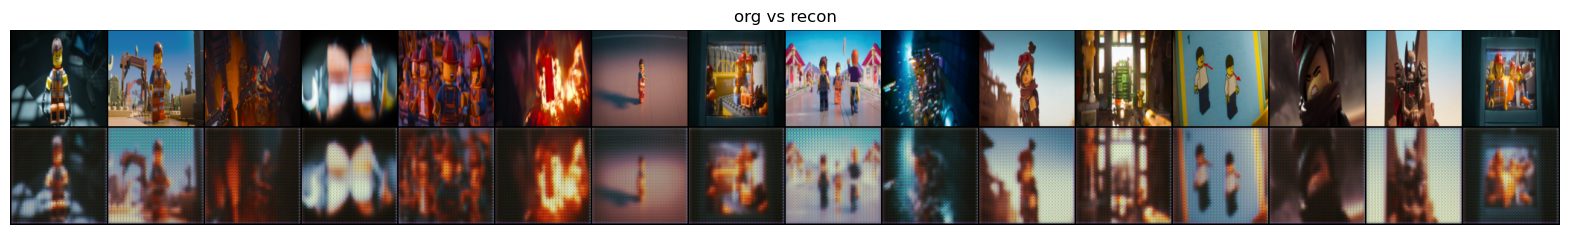

In [6]:
show_result(model, val_loader, device)

In [ ]:
torch.save(model.state_dict(), "autoencoder.pth")
model.load_state_dict(torch.load("autoencoder.pth", map_location=device))

<All keys matched successfully>